# Caelum-Incognitum – Model Test Notebook

This notebook loads your trained model (`outputs/best_model.pt`) and inference configuration (`outputs/config.json`), then lets you:

- Run **single-image inference** (with open-set **unknown** rejection if enabled)
- Run **batch inference** on a folder
- Optionally compute simple evaluation metrics if your test images are organized in subfolders by class


In [ ]:
# If you get import errors, install dependencies in the same environment as Jupyter:
# !pip install torch torchvision pillow matplotlib scikit-learn ipywidgets

import json
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

import matplotlib.pyplot as plt
from torchvision import models, transforms

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


In [ ]:
# ---------- Paths (edit if needed) ----------
PROJECT_ROOT = Path(".")  # typically the repo root
CKPT_PATH = PROJECT_ROOT / "outputs" / "best_model.pt"
CONFIG_PATH = PROJECT_ROOT / "outputs" / "config.json"

print("Checkpoint:", CKPT_PATH.resolve())
print("Config:     ", CONFIG_PATH.resolve())
print("Checkpoint exists?", CKPT_PATH.exists())
print("Config exists?    ", CONFIG_PATH.exists())


In [ ]:
# ---------- Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


In [ ]:
# ---------- Load config ----------
with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    cfg = json.load(f)

mode = cfg.get("mode", "osr_threshold")
print("Config mode:", mode)
cfg


In [ ]:
# ---------- Load checkpoint (contains model weights + training args) ----------
ckpt = torch.load(CKPT_PATH, map_location=device)
train_args = ckpt.get("args", {})  # saved training CLI args
train_args


In [ ]:
# ---------- Build the same model architecture ----------
def build_model(num_classes: int, backbone: str = "resnet18") -> nn.Module:
    if backbone == "resnet18":
        m = models.resnet18(weights=None)  # weights not needed for inference; we load trained weights
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        return m
    if backbone == "resnet50":
        m = models.resnet50(weights=None)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        return m
    raise ValueError("Unsupported backbone: " + str(backbone))

# Determine model output classes
# - closed_set_4way: 4 classes
# - osr_threshold: 3 known classes + unknown via threshold
if mode == "closed_set_4way":
    num_classes = 4
else:
    num_classes = 3

backbone = train_args.get("backbone", "resnet18")
model = build_model(num_classes=num_classes, backbone=backbone).to(device)
model.load_state_dict(ckpt["model_state"])
model.eval()

print("Loaded model:", backbone, "| num_classes:", num_classes)


In [ ]:
# ---------- Preprocessing (must match eval transforms used in training) ----------
img_size = int(train_args.get("img_size", 224))

eval_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

print("Image size:", img_size)


In [ ]:
# ---------- OSR helpers ----------
def confidence_score(logits: torch.Tensor) -> torch.Tensor:
    return F.softmax(logits, dim=1).max(dim=1).values

def load_known_class_mapping(cfg: dict):
    """Returns compact index -> class name mapping for osr_threshold mode."""
    known = cfg.get("known_classes", {})
    # JSON keys may be strings; normalize to int keys
    mapping = {int(k): v for k, v in known.items()}
    return mapping

# For osr_threshold mode
thr = float(cfg.get("threshold", 0.0)) if mode != "closed_set_4way" else None
known_map = load_known_class_mapping(cfg) if mode != "closed_set_4way" else None

print("Threshold:", thr)
print("Known mapping:", known_map)


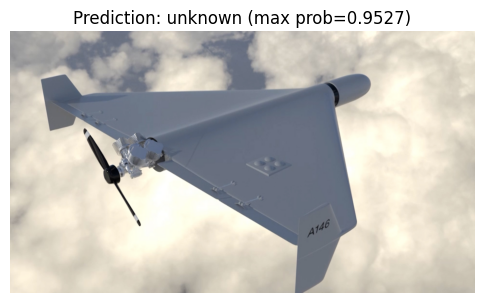

Probabilities: [4.1014009e-05 9.5268804e-01 4.7270898e-02]


In [ ]:
# ---------- Single-image inference ----------
def predict_image(image_path: str):
    p = Path(image_path)
    if not p.exists():
        raise FileNotFoundError(str(p))

    img = Image.open(p).convert("RGB")
    x = eval_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = int(np.argmax(probs))
        conf = float(np.max(probs))

    if mode == "closed_set_4way":
        # class names are the dataset folder names in alphabetical order
        # using config's idx_to_class if present, otherwise fallback
        idx_to_class = cfg.get("idx_to_class", None)
        if idx_to_class is not None:
            # json keys may be strings
            idx_to_class = {int(k): v for k, v in idx_to_class.items()}
            pred_name = idx_to_class[pred_idx]
        else:
            pred_name = str(pred_idx)
        return img, pred_name, conf, probs

    # osr_threshold mode
    if conf < thr:
        return img, "unknown", conf, probs

    pred_name = known_map.get(pred_idx, str(pred_idx))
    return img, pred_name, conf, probs
    
# --- set a path here ---
TEST_IMAGE_PATH = ""  # e.g. r"data/bird/some_image.jpg"

if TEST_IMAGE_PATH:
    img, pred_name, conf, probs = predict_image(TEST_IMAGE_PATH)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {pred_name} (max prob={conf:.4f})")
    plt.show()
    print("Probabilities:", probs)
else:
    print("Set TEST_IMAGE_PATH to run a prediction.")


## Optional: File picker (ipywidgets)

If you are running Jupyter locally, you can use this widget-based picker. If widgets do not render, use the `TEST_IMAGE_PATH` variable in the previous cell.


In [ ]:
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    file_picker = widgets.Text(
        value="",
        placeholder=r"Paste an image path here (e.g., data\bird\img.jpg)",
        description="Image:",
        layout=widgets.Layout(width="90%")
    )
    run_btn = widgets.Button(description="Run prediction", button_style="primary")

    out = widgets.Output()

    def on_click(_):
        with out:
            clear_output(wait=True)
            if not file_picker.value.strip():
                print("Please paste an image path.")
                return
            img, pred_name, conf, probs = predict_image(file_picker.value.strip())
            plt.figure(figsize=(6,6))
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Prediction: {pred_name} (max prob={conf:.4f})")
            plt.show()
            print("Probabilities:", probs)

    run_btn.on_click(on_click)
    display(file_picker, run_btn, out)

except Exception as e:
    print("ipywidgets not available or failed to load:", e)


## Batch inference on a folder

Two common folder layouts:

### A) Flat folder (no labels)
```
my_test_images/
  img1.jpg
  img2.png
```
This will just output predictions.

### B) Labeled folder (subfolders named by class)
```
my_test_images/
  aircraft/
  bird/
  drone/
  unknown/
```
This will compute basic metrics. For OSR mode, the model predicts {aircraft,bird,drone,unknown}.


In [ ]:
from collections import defaultdict

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def iter_images(root: Path):
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            yield p

def batch_predict(root_dir: str, assume_labeled_subfolders: bool = True, max_images: int | None = None):
    root = Path(root_dir)
    if not root.exists():
        raise FileNotFoundError(str(root))

    y_true = []
    y_pred = []
    records = []

    # Determine allowed labels for reports
    if mode == "closed_set_4way":
        idx_to_class = cfg.get("idx_to_class", None)
        if idx_to_class is not None:
            idx_to_class = {int(k): v for k, v in idx_to_class.items()}
            valid_labels = list(idx_to_class.values())
        else:
            valid_labels = ["0","1","2","3"]
    else:
        valid_labels = ["aircraft", "bird", "drone", "unknown"]

    count = 0
    for img_path in iter_images(root):
        if max_images is not None and count >= max_images:
            break
        count += 1

        img, pred_name, conf, _ = predict_image(str(img_path))
        records.append((str(img_path), pred_name, conf))

        if assume_labeled_subfolders:
            # true label = immediate parent folder name
            true_label = img_path.parent.name
            if true_label in valid_labels:
                y_true.append(true_label)
                y_pred.append(pred_name)

    return records, y_true, y_pred

# --- set a folder path here ---
TEST_FOLDER = ""  # e.g. r"data" or r"my_test_images"

if TEST_FOLDER:
    records, y_true, y_pred = batch_predict(TEST_FOLDER, assume_labeled_subfolders=True, max_images=None)
    print("Predicted", len(records), "images.")
    print("First 10 predictions:")
    for r in records[:10]:
        print(r)

    if len(y_true) > 0:
        print("\nEvaluation on labeled subset:")
        print("Accuracy:", accuracy_score(y_true, y_pred))
        # For unknown detection F1 (binary)
        true_is_unknown = [1 if t == "unknown" else 0 for t in y_true]
        pred_is_unknown = [1 if p == "unknown" else 0 for p in y_pred]
        print("F1 (unknown detection):", f1_score(true_is_unknown, pred_is_unknown))

        labels = sorted(set(y_true) | set(y_pred))
        print("\nClassification report:")
        print(classification_report(y_true, y_pred, labels=labels))

        print("\nConfusion matrix (rows=true, cols=pred):")
        print("Labels:", labels)
        print(confusion_matrix(y_true, y_pred, labels=labels))
    else:
        print("\nNo labeled subfolders detected (or folder names don't match expected labels).")
else:
    print("Set TEST_FOLDER to run batch predictions.")


## Visualize a few random predictions from a folder

In [ ]:
import random

def show_random_predictions(root_dir: str, n: int = 9):
    root = Path(root_dir)
    imgs = [p for p in iter_images(root)]
    if not imgs:
        print("No images found.")
        return
    sample = random.sample(imgs, k=min(n, len(imgs)))

    cols = 3
    rows = int(np.ceil(len(sample) / cols))
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, p in enumerate(sample, 1):
        img, pred_name, conf, _ = predict_image(str(p))
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{pred_name}\n{conf:.3f}\n{p.name}")

    plt.tight_layout()
    plt.show()

# --- set a folder path here ---
VIS_FOLDER = ""  # e.g. r"data"

if VIS_FOLDER:
    show_random_predictions(VIS_FOLDER, n=9)
else:
    print("Set VIS_FOLDER to visualize predictions.")
